# 3. Test

In [49]:
import sys, os
import pandas as pd
sys.path.append("../../../../")

from Clust.setting import influx_setting_KETI as ins
from Clust.clust.ingestion.influx import influx_client_v2 as influx_Client
from Clust.clust.ingestion.mongo.mongo_client import MongoClient
db_client = influx_Client.InfluxClient(ins.CLUSTDataServer2)
mongo_client = MongoClient(ins.CLUSTMetaInfo2)

import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"{device}" " is available.")

cuda is available.


In [50]:
from Clust.clust.ML.common import ML_pipeline

## 1. Data Preparation

In [54]:
app_name= "Hs2SwineFarmWithWeatherTime" # "Hs2SwineFarmWithWeatherTime", "energy"
model_method = 'GRU_rg'
model_clean = True
step = 'test'
bucket_name = 'integration'
data_clean_level=0

In [55]:
model_name = None
model_name = ML_pipeline.get_default_model_name(model_name, app_name, model_method, model_clean)
collection_name = 'meta'
db_name = 'model'
model_meta_list= mongo_client.get_document_by_json(db_name, collection_name, {'modelName': model_name})
model_meta = model_meta_list[0] ## ??

### 1-2. Data Ingestion
#### 1-2-1. X-y Data Ingestion pipeline

In [57]:
model_purpose = model_meta['modelPurpose']
dataset_name = model_purpose + '_' + app_name  
scaler_param= model_meta['scalerParam']
data_name_X = dataset_name + '_cleanLevel' + str(data_clean_level)+'_'+step+'X'
data_name_y = dataset_name+'_cleanLevel' + str(data_clean_level)+'_'+ step+'y'
data_y_flag = model_meta['data_y_flag']

In [58]:
feature_X_list = model_meta['featureXList']
feature_y_list = model_meta["featureyList"]
model_file_path = model_meta['files']['modelFile']["filePath"]

In [59]:
# Data Ingestion
ingestion_method = 'ms_all'
ingestion_param_X = {
    "bucket_name" : bucket_name,
    'ms_name' : data_name_X,
    'feature_list' : feature_X_list                              
}
ingestion_param_y = {
    "bucket_name" : bucket_name,
    'ms_name' : data_name_y,
    'feature_list' : feature_y_list                              
}

In [60]:
data_X, data_y = ML_pipeline.get_Xy_data_in_Clust(ingestion_param_X, data_y_flag, ingestion_param_y, ingestion_method, db_client)

#### 1-2-2. Random Nan Insert (Test)
#### 1-2-3. Data scaling

In [61]:
X_scaler_file_path = model_meta['files']['XScalerFile']["filePath"]
y_scaler_file_path = model_meta['files']['yScalerFile']["filePath"]
y_scaler_file_path

'./scaler/forecasting_Hs2SwineFarmWithWeatherTime_cleanLevel0_trainy/minmax/2ef658edf359871df2a5d6f044a18200/scaler.pkl'

In [62]:
scaler_param = model_meta["scalerParam"]
from Clust.clust.ML.tool import scaler as ml_scaler
test_X, scaler_X = ml_scaler.get_scaled_test_data(data_X, X_scaler_file_path, scaler_param)
test_y, scaler_y = ml_scaler.get_scaled_test_data(data_y, y_scaler_file_path, scaler_param)

#### 1-2-2. Random Nan Insert (Test)
#### 1-2-3. Data scaling

In [63]:
split_mode = model_meta['dataSplitMode']
transformParameter = model_meta["transformParameter"]
test_X_array, test_y_array = ML_pipeline.get_transfomed_data(split_mode, transformParameter, test_X, test_y)

nan_limit_num:  12
Original num: 2005 Final num: 1979 NaN num: 26


In [64]:
modelParameter = model_meta["modelParameter"]

testParameter = {
    'device': 'cpu',
    'batch_size': model_meta["trainParameter"]['batch_size']
}

In [65]:
#3. Test model
from Clust.clust.ML.regression_YK.test import RegressionTest as RT

rt = RT()
rt.set_param(testParameter)
rt.set_model(model_method, model_file_path, modelParameter)
rt.set_data(test_X_array, test_y_array)
preds, trues = rt.test()

features shape: torch.Size([1979, 24, 3]) targets shape:  torch.Size([1979, 1])

Start testing data



In [66]:
print(test_X_array.shape, test_y_array.shape)
print(preds.shape, trues.shape)

(1979, 24, 3) (1979, 1)
(1968,) (1968,)


In [67]:
data_y_flag

False

scale
          value  prediction
0     25.099999   25.167728
1     25.250000   25.232505
2     25.366666   25.282783
3     25.400001   25.338711
4     25.533334   25.408292
...         ...         ...
1963  19.900000   20.220840
1964  20.133333   20.209098
1965  20.350000   20.213702
1966  20.300000   20.225049
1967  20.549999   20.280253

[1968 rows x 2 columns]
{'mae': 0.3657840028041746, 'rmse': 0.4690967171288232, 'r2': 0.9460762901798039, 'mape': 1.5007787768725835}


<Axes: >

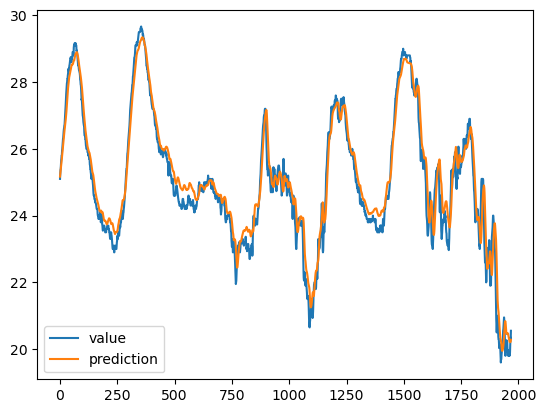

In [68]:
from Clust.clust.tool.stats_table import metrics
if data_y_flag:
    scaler = scaler_y
    feature_list = feature_y_list
    target = feature_y_list[0]
else:
    scaler = scaler_X
    feature_list = feature_X_list
    target = feature_y_list[0]
    
from Clust.clust.ML.tool import data as ml_data 
df_result = ml_data.get_prediction_df_result(preds, trues, scaler_param, scaler, feature_list, target)
result_metrics =  metrics.calculate_metrics_df(df_result)
print(df_result)
print(result_metrics)
df_result.plot()

In [69]:
# 5. Only For IPython Notebook
from Clust.clust.tool.plot.plot_two_data import plot_predictions
import plotly.offline as pyo
# Set notebook mode to work in offline
pyo.init_notebook_mode()
plot_predictions(df_result)

ModuleNotFoundError: No module named 'chart_studio'